In [ ]:
#We did some tests with pytest. Now we want to experiment with writing some tests with fastai/fastcore and also 
#with using the nbdev procedure etc. 

In [ ]:
# !pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
# !pip install fastai==2.6.3 --no-deps
# !pip install self_supervised

# !pip install pytest
# !pip install ipytest

In [1]:
import fastai
import self_supervised

import torch
if torch.cuda.is_available():device='cuda'
else:device='cpu'
    
assert(fastai.__version__ == '2.6.3') #Check that version is 2.6.3
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")

/Users/hamishhaggerty/opt/anaconda3/envs/old_fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")

# import ipytest
# ipytest.autoconfig()
# import pytest

In [3]:
from fastcore import *

In [10]:
from fastcore.test import *

In [13]:
test([1,2],[1,2], operator.eq)

In [14]:
import logging
logging.getLogger('PIL').setLevel(logging.WARNING)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [15]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))

In [16]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [17]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [18]:
#Uniform random number between a and b
def Unif(a,b):
    return (b-a)*torch.rand(1).item()+a

In [19]:
def random_sinusoid(x,std=0.15):
    
    t=torch.normal(mean=0,std=std,size=(1,1)).item()
    s=torch.normal(mean=0,std=std,size=(1,1)).item()
    
    u=torch.normal(mean=0,std=1,size=(1,1)).item()
    v=torch.normal(mean=0,std=1,size=(1,1)).item()
    
    a=torch.normal(mean=0,std=1,size=(1,1)).item()
    b=torch.normal(mean=0,std=1,size=(1,1)).item()
    
    return torch.sin(t*math.pi*x+u) + torch.cos(s*math.pi*x + v)

In [20]:
def random_sinusoid_new(x,std=0.1,seed=0):

    seed_everything(seed=seed)
    
    t=(std) * torch.randn(1,500).to(device)
    #s=(std) * torch.randn(1,500).to(device)
    
    #u=torch.randn(1,500).to(device)
    #v=torch.randn(1,500).to(device)

    return torch.sin(t*x[:,]*math.pi)# + u) + torch.cos(s*x[:,]*math.pi + v)

    #return torch.sin(t*math.pi*x+u) + torch.cos(s*math.pi*x + v)

In [21]:
def Exp_sample(scale=3.,loc=1.8):
    
    Expo = torch.distributions.exponential.Exponential
    E = Expo(torch.tensor([scale]))
#     if random.random()<0.5:
#         return 1
#     else:
    return loc+E.sample().item()

In [22]:
def p_norm(x,p):

    eps=1e-8
    if p<1:
        x=x+eps
    return (1/p)*torch.abs(x).pow(p)

In [23]:
class Max_Corr(nn.Module):
    def __init__(self):
        super().__init__()
        #self.fc1 = nn.Linear(500,1)
        #self.fc2 = nn.Linear(500,1)
        self.t = nn.Parameter(0.1*torch.randn(1,500),requires_grad=True)
        self.s = nn.Parameter(0.1*torch.randn(1,500),requires_grad=True)
        
    def forward(self,x,y):
        
        return (torch.sin(self.t*x[:,]*math.pi),torch.sin(self.s*y[:,]*math.pi))
        
        
        #return (torch.sin(cast(self.fc1(x[:,])*math.pi,Tensor)),torch.sin(cast(self.fc2(y[:,])*math.pi,Tensor)))
        

In [24]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.index=-1
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):

        #if self.index%8 == 0: #every `indexmod` index update the seed (best we have found so far)

        self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1
            
    def before_batch(self):
                
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1

        self.update_seed()

        
        #Uncomment to run standard BT
    # def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
    #     bs,nf = pred.size(0)//2,pred.size(1)

    #     z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

    #     z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    #     z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
    #     C = (z1norm.T @ z2norm) / bs 
    #     cdiff = (C - self.I)**2
    #     loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
    #     return loss


    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        max_corr=inner_step(z1norm,z2norm,I=self.I)
        z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
        
        Ctem = (z1norm_2.T @ z2norm_2) / bs
        cdiff_2 = Ctem.pow(2)

        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2



        #{'Pr': 0.45546983480453496, 'dist': 'Exp', 'loc': 0.49445648193359376, 'scale': 2.5828861594200134, 'percent_correct': 0.8277832269668579} #Best so far

        #self.update_seed()

        #input('hi')

        #polyprob=0.1
        #polyprob=0.45546
        #polyprob=1.0
#         polyprob=0.0
#         temrand = random.random()
#         if temrand < polyprob: #With some probability we want off diag terms to be (quadratic) say.

#             K=10
#             cdiff_2=0
#             for i in range(K):
#             #p=Exp_sample(loc=1.5,scale=2.0)
#             # #p=Unif(1.0,2.5)
#                 z1norm_2 = random_sinusoid_new(z1norm,std=0.1,seed=self.seed+i)
#                 z2norm_2 = random_sinusoid_new(z2norm,std=0.1,seed=2*self.seed+i)
#                 C_2 = (z1norm_2.T @ z2norm_2) / bs
#                 #cdiff_2 = (C_2)**2 #don't need to subtract I as only looking at off diag terms
#                 cdiff_2 = cdiff_2 + (C_2)**2
            
#             cdiff_2=(1/K)*cdiff_2

#             #symmetrize loss - so copy paste above block but swap place of 1 and 2
#             #p=Exp_sample(loc=1.5,scale=2.0)
#             #p=Unif(1.0,2.5)
            
#             # cdiff_2_sym=0
#             # for i in range(K):
#             #     z1norm_2 = random_sinusoid_new(z1norm,std=0.1,seed=4*self.seed+i)
#             #     z2norm_2 = random_sinusoid_new(z2norm,std=0.1,seed=8*self.seed+i)

#             #     C_2_sym = (z1norm_2.T @ z2norm_2) / bs
#             #     cdiff_2_sym = cdiff_2_sym + C_2_sym**2
            
#             # cdiff_2_sym=(1/K)*cdiff_2_sym

#             cdiff_2 = cdiff_2 #+ 0.5*cdiff_2_sym #Symmetrized random loss

#             cdiff_2 = 0.2*cdiff +  0.8*cdiff_2 #convex comb of BT loss with random loss -> assumes polyprob=1.0
            
#         else:
#             cdiff_2 = cdiff
            
            
            
        l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

        loss = (cdiff*self.I + l2).sum() 
        return loss


    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [25]:
#Debugging cell - delete later (similar to cell below)
ps=500
hs=500
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=(device=='cuda'))
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn.fit(10) #300                            

NameError: name 'dls' is not defined

In [26]:
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def tune_set(items0,bs_tune=20):
    items0=items0.shuffle()
    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
    ITEMS=[]
    for i in items0:
        s=str(i).split('/training/')[1][0]
        if d[s] is 0 or d[s] is 1:
            ITEMS.append(i)
            d[s]+=1
    #items0=ITEMS

    for i in items0:
        if i not in ITEMS:
            ITEMS.append(i)
            
    split = IndexSplitter(list(range(bs_tune)))

    tds_tune = Datasets(ITEMS, [PILImageBW.create, [parent_label, Categorize()]], splits=split(ITEMS)) #Or do we want this?
    dls_tune = tds_tune.dataloaders(bs=bs_tune,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)
    
    return dls_tune

 

In [27]:
#TODO: Do this in a slicker way. Write more tests 
#Get the dataloader and set batch size 
ts=16384 #training set size
bs=512 #training batch size

tune_s=2000 #we choose (say) 20 guys (randomly) out of theses 2000 to tune on
bs_tune=20 #With MNIST this is also the size of the tune set

bs_test=578 #Batch size for test set

#Get the data
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort() 

#Set random seed when defining/extracting training set, tuning set testing set for reproducibility
seed=42
seed_everything(seed=seed)
items=items.shuffle()

#Training set (for BT)
items1 = items[0:ts] #train BT on these guys
split = RandomSplitter(valid_pct=0.0)
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)

#We use items0 to extract tuning set, via the function `tune_set` above
items0 = items[ts:ts+tune_s] #for fine tuning - just choose 2000 guys to extract 20 for fine tuning 

#Evaluate linear classifier on this guy
test_bs=578
items2 = items[ts+tune_s:] #test on the remaining set
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
tds_test = Datasets(items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_test = tds_test.dataloaders(bs=bs_test,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)

In [28]:
# %%ipytest -qq
# #Test dataloaders

# labeller = using_attr(RegexLabeller(pat = r'(\d+).png$'), 'name')

# def verify_DatasetShape(dls_obj,batch_size,ds_settype='train'):
#     """"Helper function to verify shape of a dls object given the batch size; ds_settype is either `train` or 
#         `valid`. The idea is we want the batch_size to divide the length of the dlsobj.
#     """
    
#     tem = len(getattr(dls_obj,ds_settype)) #length of dlsobj.train or dlsobj.valid depending on settpe
#     return tem*batch_size == len(getattr(dls_obj,ds_settype+'_ds'))

# def verify_first_item(items,expected):
#     """Helper function to verify first element of items is as expected, given random seed of 42
#     """
#     if seed==42:
#         return labeller(items[0]) == expected
#     else:
#         logging.debug('The seed is not 42 - is this ok?')
#         return False

# dls_tune=tune_set(items0,bs_tune=bs_tune) #used for generic tests below

# def test_first_item():
#     """"Verify that the first item of each dls_obj is as expected
#     """
    
#     assert verify_first_item(items1,'19825')
    
#     assert verify_first_item(items0,'40684')
    
#     assert verify_first_item(items2,'43064')
    
# def test_shape_dlsobjects():
#     """"Test the shape of each dlsobj
#     """
    
#     assert verify_DatasetShape(dls,batch_size=bs,ds_settype='train')
    
#     assert verify_DatasetShape(dls_tune,batch_size=bs_tune,ds_settype='valid')
    
#     assert verify_DatasetShape(dls_test,batch_size=bs_test,ds_settype='train')
    
# def test_length_dlsobjects():
#     """"Test the length of each dlsobj that we use
#     """
    
#     assert len(dls.train_ds) == ts and len(dls_tune.valid_ds) == bs_tune and len(dls_test.train_ds)==41616
    
# def test1_tune_set():
#     """Check whether the function `tune_set` gives us the expected values"""
    
#     tune_seed=10
#     expected = {10:0.12255,11:0.153564,12:0.12781,13:0.129523,14:0.13019}
#     for i in range(5):
#         seed=tune_seed+i
#         seed_everything(seed=seed)
#         dls_tune=tune_set(items0,bs_tune=20)
#         x_mean=0
#         for x,y in dls_tune.valid:
#             x_mean += x.mean()

#         assert abs(x_mean-expected[seed])<0.0001


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


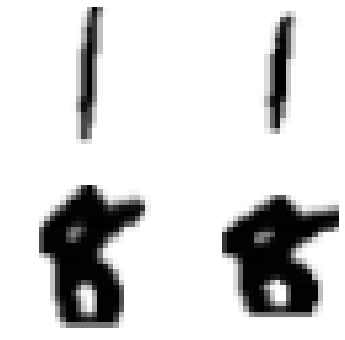

In [30]:
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

#dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=2)

In [31]:
#Simple linear classifier
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

In [32]:
def turnoffgrad_model(fastai_encoder):
    for p in fastai_encoder.parameters():
        p.requires_grad=False
        
    return fastai_encoder

In [33]:
#NB: Will give same random 20-tune set (for fixed random seed), only if the cell
#"#Get the dataloader and set batch size" is the same. Perhaps later we can make this cell a function of that one. 
#Functions to train and evaluate head
fastai_encoder.eval()
encoder_nograd = turnoffgrad_model(fastai_encoder) 
def train_head(encoder_nograd,tune_seed=10,bs_tune=20): #The seed choses a different (20) samples for training the head. 2 of each class
    """Train head on a tune_set, chosen through given tune_seed for reproducibility if needed
    """
    seed_everything(seed=tune_seed) #Set the random seed, so that we choose a `fixed` tune set (i.e. as a function
                                    # of the tune_seed)
    dls_tune=tune_set(items0,bs_tune=bs_tune) #different random tune set each time (but as a function of tune_seed)
 
    N=len(dls_tune.valid)*bs_tune 
    assert N == len(dls_tune.valid_ds) #Check that the tune set (valid) is divided by the batch size
    assert len(dls_tune.valid_ds) == bs_tune

    zdim=1024 #see above
    head = LinearClassifier(zdim=zdim)
    head.to(device)
    optimizer = torch.optim.Adam(head.parameters())
    criterion = nn.CrossEntropyLoss()
    for epoch in range(200):
        #for x,y in dls_tune.valid: #Slows massively on colab but not on kaggle. Weird. 
        x,y=dls_tune.valid.one_batch() #Same every time since dataset only has length=batch size = 20.
                                        #Will need to fix this for CIFAR10 etc

        loss = criterion(head(encoder_nograd(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return head

@torch.no_grad()
def eval_head(head):
    """Evaluate the (typically trained) head on on the test set
    """
    N=len(dls_test.train)*bs_test 
    assert N == len(dls_test.train_ds)

    num_correct=0
    for x,y in dls_test.train:
    #for i in range(3):

        ypred = head(encoder_nograd(x))
        correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
        num_correct += correct.sum()
    
    return num_correct/N

def eval_encoder(encoder_nograd,tune_seed=10):
    """"Evaluate the encoder, which means to train and evaluate the head - basically wrap functions train_head
        and eval_head
    """
    head=train_head(encoder_nograd,tune_seed=tune_seed)
    pct_correct = eval_head(head)
    return pct_correct
    

In [ ]:
%%time
tune_seed=10
performance_dict={}
for num in range(1):
    
    pct_correct = eval_encoder(encoder_nograd,tune_seed=tune_seed+num)
    performance_dict[f'seed_{num}'] = pct_correct 

print(torch.mean(tensor(list(performance_dict.values()))))
performance_dict

In [35]:
test([1,2],[1,2], operator.eq)